In [47]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, factor, srepr, Add, Symbol, Integer, Float
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from fdlib import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
U,V,W,Txx,Tyy,Tzz,Txy,Tyz,Txz = IndexedBases('U V W Txx Tyy Tzz Txy Tyz Txz')
b, lam, mu = IndexedBases('beta lambda mu')
x,y,z,t,h,dt = symbols('x y z t h dt')

In [3]:
accuracy_time = 1 # O(dt^2) accuracy in time domain
accuracy_space = 2 # O(h^4) accuracy in space domain

###Calculate FD approximation of derivatives

In [4]:
l = [t,x,y,z]

# first-order time derivatives in velocities and stresses
# O(dt^2) accuracy
DtU = Deriv_half(U,l,0,dt,accuracy_time)[1]
DtV = Deriv_half(V,l,0,dt,accuracy_time)[1]
DtW = Deriv_half(W,l,0,dt,accuracy_time)[1]

DtTxx = Deriv_half(Txx,l,0,dt,accuracy_time)[1]
DtTxy = Deriv_half(Txy,l,0,dt,accuracy_time)[1]
DtTxz = Deriv_half(Txz,l,0,dt,accuracy_time)[1]
DtTyy = Deriv_half(Tyy,l,0,dt,accuracy_time)[1]
DtTyz = Deriv_half(Tyz,l,0,dt,accuracy_time)[1]
DtTzz = Deriv_half(Tzz,l,0,dt,accuracy_time)[1]

# first-order spacial derivatives of velocities and stresses
# O(h^4) accuracy

DxU = Deriv_half(U,l,1,h,accuracy_space,shift_forward=False)[1]
DyV = Deriv_half(V,l,2,h,accuracy_space,shift_forward=False)[1]
DzW = Deriv_half(W,l,3,h,accuracy_space,shift_forward=False)[1]

DyU = Deriv_half(U,l,2,h,accuracy_space)[1]
DzU = Deriv_half(U,l,3,h,accuracy_space)[1]
DxV = Deriv_half(V,l,1,h,accuracy_space)[1]
DzV = Deriv_half(V,l,3,h,accuracy_space)[1]
DxW = Deriv_half(W,l,1,h,accuracy_space)[1]
DyW = Deriv_half(W,l,2,h,accuracy_space)[1]

DxTxx = Deriv_half(Txx,l,1,h,accuracy_space)[1]
DyTyy = Deriv_half(Tyy,l,2,h,accuracy_space)[1]
DzTzz = Deriv_half(Tzz,l,3,h,accuracy_space)[1]

DxTxy = Deriv_half(Txy,l,1,h,accuracy_space,shift_forward=False)[1]
DyTxy = Deriv_half(Txy,l,2,h,accuracy_space,shift_forward=False)[1]
DyTyz = Deriv_half(Tyz,l,2,h,accuracy_space,shift_forward=False)[1]
DzTyz = Deriv_half(Tyz,l,3,h,accuracy_space,shift_forward=False)[1]
DxTxz = Deriv_half(Txz,l,1,h,accuracy_space,shift_forward=False)[1]
DzTxz = Deriv_half(Txz,l,3,h,accuracy_space,shift_forward=False)[1]

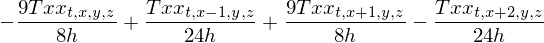

In [6]:
DxTxx

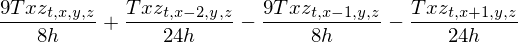

In [7]:
# note difference between shift_forward True/False
DxTxz

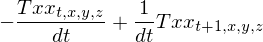

In [7]:
DtTxx

###PDEs

In [8]:
# momentum equations
# no need to replace t here
eq1 = Eq(DtU, b[t,x,y,z]*(DxTxx + DyTxy + DzTxz))
eq2 = Eq(DtV, b[t,x,y,z]*(DxTxy + DyTyy + DzTyz))
eq3 = Eq(DtW, b[t,x,y,z]*(DxTxz + DyTyz + DzTzz))

# stress-strain equations
eq4 = Eq(DtTxx, (lam[t,x,y,z] + 2*mu[t,x,y,z])*DxU + lam[t,x,y,z]*(DyV+DzW))
eq5 = Eq(DtTyy, (lam[t,x,y,z] + 2*mu[t,x,y,z])*DyV + lam[t,x,y,z]*(DxU+DzW))
eq6 = Eq(DtTzz, (lam[t,x,y,z] + 2*mu[t,x,y,z])*DzW + lam[t,x,y,z]*(DxU+DyV))
eq7 = Eq(DtTxy, mu[t,x,y,z]*(DyU+DxV))
eq8 = Eq(DtTxz, mu[t,x,y,z]*(DzU+DxW))
eq9 = Eq(DtTyz, mu[t,x,y,z]*(DzV+DyW))

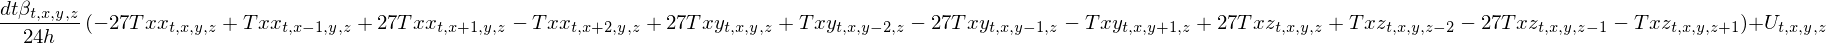

In [9]:
# for demo only
simplify(solve(eq1,U[t+1,x,y,z])[0]-U[t,x,y,z])+U[t,x,y,z]

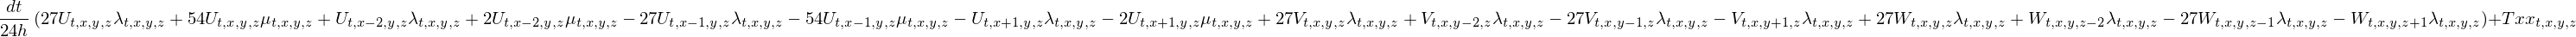

In [10]:
# for demo only
simplify(solve(eq4,Txx[t+1,x,y,z])[0]-Txx[t,x,y,z])+Txx[t,x,y,z]

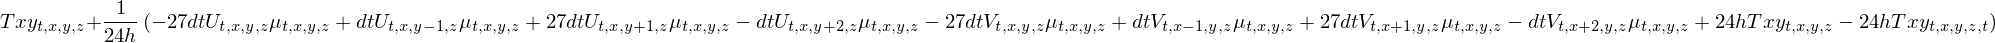

In [11]:
# for demo only
# note difference between Txx and Txy indices
simplify(solve(eq7,Txy[t+1,x,y,z])[0]-Txy[t,x,y,z,t])+Txy[t,x,y,z]

###solve for FD stencil

In [12]:
# generate computation code segments
U_t = print_assignment(eq1, U[t+1,x,y,z], U[t,x,y,z], pochoir=True)
V_t = print_assignment(eq2, V[t+1,x,y,z], V[t,x,y,z], pochoir=True)
W_t = print_assignment(eq3, W[t+1,x,y,z], W[t,x,y,z], pochoir=True)
Txx_t = print_assignment(eq4, Txx[t+1,x,y,z], Txx[t,x,y,z], pochoir=True)
Tyy_t = print_assignment(eq5, Tyy[t+1,x,y,z], Tyy[t,x,y,z], pochoir=True)
Tzz_t = print_assignment(eq6, Tzz[t+1,x,y,z], Tzz[t,x,y,z], pochoir=True)
Txy_t = print_assignment(eq7, Txy[t+1,x,y,z], Txy[t,x,y,z], pochoir=True)
Txz_t = print_assignment(eq8, Txz[t+1,x,y,z], Txz[t,x,y,z], pochoir=True)
Tyz_t = print_assignment(eq9, Tyz[t+1,x,y,z], Tyz[t,x,y,z], pochoir=True)

In [13]:
# they look like this
Txx_t

'Txx(t + 1,x,y,z)=(1.0/24.0)*dt*(27*U(t,x,y,z)*lambda(t,x,y,z) + 54*U(t,x,y,z)*mu(t,x,y,z) + U(t,x - 2,y,z)*lambda(t,x,y,z) + 2*U(t,x - 2,y,z)*mu(t,x,y,z) - 27*U(t,x - 1,y,z)*lambda(t,x,y,z) - 54*U(t,x - 1,y,z)*mu(t,x,y,z) - U(t,x + 1,y,z)*lambda(t,x,y,z) - 2*U(t,x + 1,y,z)*mu(t,x,y,z) + 27*V(t,x,y,z)*lambda(t,x,y,z) + V(t,x,y - 2,z)*lambda(t,x,y,z) - 27*V(t,x,y - 1,z)*lambda(t,x,y,z) - V(t,x,y + 1,z)*lambda(t,x,y,z) + 27*W(t,x,y,z)*lambda(t,x,y,z) + W(t,x,y,z - 2)*lambda(t,x,y,z) - 27*W(t,x,y,z - 1)*lambda(t,x,y,z) - W(t,x,y,z + 1)*lambda(t,x,y,z))/h + Txx(t,x,y,z)'

In [14]:
# and this
U_t

'U(t + 1,x,y,z)=(1.0/24.0)*dt*(-27*Txx(t,x,y,z) + Txx(t,x - 1,y,z) + 27*Txx(t,x + 1,y,z) - Txx(t,x + 2,y,z) + 27*Txy(t,x,y,z) + Txy(t,x,y - 2,z) - 27*Txy(t,x,y - 1,z) - Txy(t,x,y + 1,z) + 27*Txz(t,x,y,z) + Txz(t,x,y,z - 2) - 27*Txz(t,x,y,z - 1) - Txz(t,x,y,z + 1))*beta(t,x,y,z)/h + U(t,x,y,z)'

###boundary conditions

In [73]:
# constant boundary condition
bc_const = Float(0)
# Dirichlet boundary condition
bc_dirichlet = 100 + 0.2*t
# Neumann boundary condition (expression evaluates to zero)
bc_neumann = Deriv(U,l,1,h,2)[1]-1

In [79]:
bc_neuman1 = solve(bc_neumann,U[t,x+1,y,z])[0].subs(x+1,x); assign_pochoir_bc(bc_neuman1)

'return 2*h + U(t,x - 2,y,z)'

In [58]:
bc_U_x0 = assign_pochoir_bc(bc_const); bc_U_x1 = assign_pochoir_bc(bc_const)
bc_U_y0 = assign_pochoir_bc(bc_const); bc_U_y1 = assign_pochoir_bc(bc_const)
bc_U_z0 = assign_pochoir_bc(bc_const); bc_U_z1 = assign_pochoir_bc(bc_const)

In [59]:
bc_V_x0 = assign_pochoir_bc(bc_const); bc_V_x1 = assign_pochoir_bc(bc_const)
bc_V_y0 = assign_pochoir_bc(bc_const); bc_V_y1 = assign_pochoir_bc(bc_const)
bc_V_z0 = assign_pochoir_bc(bc_const); bc_V_z1 = assign_pochoir_bc(bc_const)

In [60]:
bc_W_x0 = assign_pochoir_bc(bc_const); bc_W_x1 = assign_pochoir_bc(bc_const)
bc_W_y0 = assign_pochoir_bc(bc_const); bc_W_y1 = assign_pochoir_bc(bc_const)
bc_W_z0 = assign_pochoir_bc(bc_const); bc_W_z1 = assign_pochoir_bc(bc_const)

In [61]:
bc_Txx_x0 = assign_pochoir_bc(bc_const); bc_Txx_x1 = assign_pochoir_bc(bc_const)
bc_Txx_y0 = assign_pochoir_bc(bc_const); bc_Txx_y1 = assign_pochoir_bc(bc_const)
bc_Txx_z0 = assign_pochoir_bc(bc_const); bc_Txx_z1 = assign_pochoir_bc(bc_const)

In [62]:
bc_Tyy_x0 = assign_pochoir_bc(bc_const); bc_Tyy_x1 = assign_pochoir_bc(bc_const)
bc_Tyy_y0 = assign_pochoir_bc(bc_const); bc_Tyy_y1 = assign_pochoir_bc(bc_const)
bc_Tyy_z0 = assign_pochoir_bc(bc_const); bc_Tyy_z1 = assign_pochoir_bc(bc_const)

In [63]:
bc_Tzz_x0 = assign_pochoir_bc(bc_const); bc_Tzz_x1 = assign_pochoir_bc(bc_const)
bc_Tzz_y0 = assign_pochoir_bc(bc_const); bc_Tzz_y1 = assign_pochoir_bc(bc_const)
bc_Tzz_z0 = assign_pochoir_bc(bc_const); bc_Tzz_z1 = assign_pochoir_bc(bc_const)

In [64]:
bc_Txy_x0 = assign_pochoir_bc(bc_const); bc_Txy_x1 = assign_pochoir_bc(bc_const)
bc_Txy_y0 = assign_pochoir_bc(bc_const); bc_Txy_y1 = assign_pochoir_bc(bc_const)
bc_Txy_z0 = assign_pochoir_bc(bc_const); bc_Txy_z1 = assign_pochoir_bc(bc_const)

In [65]:
bc_Tyz_x0 = assign_pochoir_bc(bc_const); bc_Tyz_x1 = assign_pochoir_bc(bc_const)
bc_Tyz_y0 = assign_pochoir_bc(bc_const); bc_Tyz_y1 = assign_pochoir_bc(bc_const)
bc_Tyz_z0 = assign_pochoir_bc(bc_const); bc_Tyz_z1 = assign_pochoir_bc(bc_const)

In [66]:
bc_Txz_x0 = assign_pochoir_bc(bc_const); bc_Txz_x1 = assign_pochoir_bc(bc_const)
bc_Txz_y0 = assign_pochoir_bc(bc_const); bc_Txz_y1 = assign_pochoir_bc(bc_const)
bc_Txz_z0 = assign_pochoir_bc(bc_const); bc_Txz_z1 = assign_pochoir_bc(bc_const)

###output using templates

In [67]:
# write to template file
mylookup = TemplateLookup(directories=['templates/'])
mytemplate = mylookup.get_template('test_pochoir_iso_elastic_tmpl.cpp')
buf = StringIO()
dict1 = {'time_period':2,'Txx':Txx_t,'Tyy':Tyy_t,'Tzz':Tzz_t,'Txy':Txy_t,'Txz':Txz_t,'Tyz':Tyz_t,'U':U_t,'V':V_t,'W':W_t}
dict1.update({'bc_U_x0':bc_U_x0,'bc_U_x1':bc_U_x1,'bc_U_y0':bc_U_y0,'bc_U_y1':bc_U_y1,'bc_U_z0':bc_U_z0,'bc_U_z1':bc_U_z1})
dict1.update({'bc_V_x0':bc_V_x0,'bc_V_x1':bc_V_x1,'bc_V_y0':bc_V_y0,'bc_V_y1':bc_V_y1,'bc_V_z0':bc_V_z0,'bc_V_z1':bc_V_z1})
dict1.update({'bc_W_x0':bc_W_x0,'bc_W_x1':bc_W_x1,'bc_W_y0':bc_W_y0,'bc_W_y1':bc_U_y1,'bc_W_z0':bc_W_z0,'bc_W_z1':bc_W_z1})
dict1.update({'bc_Txx_x0':bc_Txx_x0,'bc_Txx_x1':bc_Txx_x1,'bc_Txx_y0':bc_Txx_y0,'bc_Txx_y1':bc_Txx_y1,'bc_Txx_z0':bc_Txx_z0,'bc_Txx_z1':bc_Txx_z1})
dict1.update({'bc_Tyy_x0':bc_Tyy_x0,'bc_Tyy_x1':bc_Tyy_x1,'bc_Tyy_y0':bc_Tyy_y0,'bc_Tyy_y1':bc_Tyy_y1,'bc_Tyy_z0':bc_Tyy_z0,'bc_Tyy_z1':bc_U_z1})
dict1.update({'bc_Tzz_x0':bc_Tzz_x0,'bc_Tzz_x1':bc_Tzz_x1,'bc_Tzz_y0':bc_Tzz_y0,'bc_Tzz_y1':bc_Tzz_y1,'bc_Tzz_z0':bc_Tzz_z0,'bc_Tzz_z1':bc_Tzz_z1})
dict1.update({'bc_Txy_x0':bc_Txy_x0,'bc_Txy_x1':bc_Txy_x1,'bc_Txy_y0':bc_Txy_y0,'bc_Txy_y1':bc_Txy_y1,'bc_Txy_z0':bc_Txy_z0,'bc_Txy_z1':bc_Txy_z1})
dict1.update({'bc_Txz_x0':bc_Txz_x0,'bc_Txz_x1':bc_Txz_x1,'bc_Txz_y0':bc_Txz_y0,'bc_Txz_y1':bc_Txz_y1,'bc_Txz_z0':bc_Txz_z0,'bc_Txz_z1':bc_Txz_z1})
dict1.update({'bc_Tyz_x0':bc_Tyz_x0,'bc_Tyz_x1':bc_Tyz_x1,'bc_Tyz_y0':bc_Tyz_y0,'bc_Tyz_y1':bc_Tyz_y1,'bc_Tyz_z0':bc_Tyz_z0,'bc_Tyz_z1':bc_Tyz_z1})
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)
code = buf.getvalue()

In [68]:
# generate compilable C++ source code
f= open('../tests/src/mytest_pochoir.cpp','w')
f.write(code)
f.close()